In [2]:
import pandas as pd
import os
from glob import glob
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
import numpy as np
import xarray as xr
from scipy.interpolate import interp2d
from datetime import datetime, timedelta
from tqdm import tqdm
from pandas.plotting import register_matplotlib_converters
# from wrf import getvar, ALL_TIMES,destagger, interplevel
register_matplotlib_converters()
import salem

In [3]:
ds_wrf = salem.open_wrf_dataset("wrfout_d05_2019-01-26_00_00_00")

In [4]:
wrf_lat = ds_wrf.lat
wrf_lon = ds_wrf.lon

In [5]:
centlat   = -43.46830000
centlon   = 172.69205000

In [6]:
ll_distance = np.abs(wrf_lat-centlat) + np.abs(wrf_lon-centlon)
nearest_latidx, nearest_lonidx = np.unravel_index(ll_distance.argmin(),ll_distance.shape)

In [7]:
nearest_latidx, nearest_lonidx

(61, 86)

(70.0, 100.0)

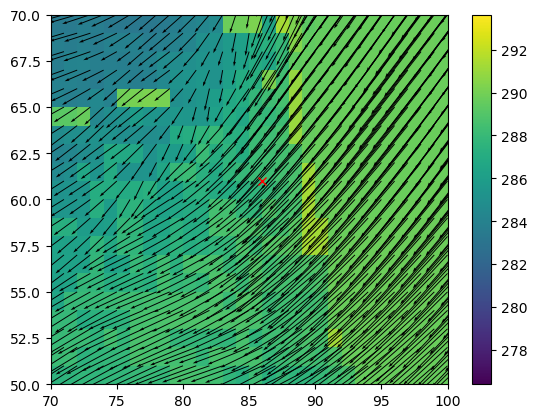

In [60]:
timestamp = "2019-02-02-16"
plt.pcolormesh(ds_wrf.T2.sel(time=timestamp))
plt.colorbar()
plt.quiver(ds_wrf.U10.sel(time=timestamp), ds_wrf.V10.sel(time=timestamp), color="k",scale=1/0.025)

plt.plot(nearest_lonidx, nearest_latidx,"rx")
plt.ylim([50,70])
plt.xlim([70,100])
# plt.grid()

In [9]:
u10 = ds_wrf.U10.isel(south_north=nearest_latidx, west_east = nearest_lonidx)
v10 =ds_wrf.V10.isel(south_north=nearest_latidx, west_east = nearest_lonidx)
wspd10= np.sqrt(u10**2+v10**2)
t2 = ds_wrf.T2.isel(south_north=nearest_latidx, west_east = nearest_lonidx)

In [10]:
plt_dates = np.arange(pd.to_datetime("2019-01-26-00"),pd.to_datetime("2019-02-03-01") , timedelta(hours=1))

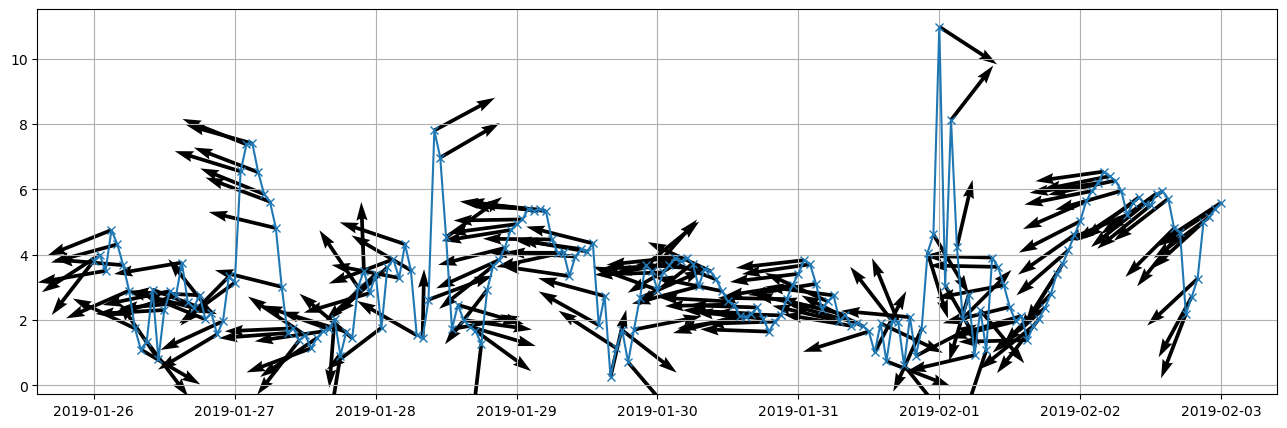

In [11]:
plt.figure(figsize=(16,5))
plt.plot(plt_dates,wspd10,"x-")
for i in range(0,len(u10)):
    plt.quiver(plt_dates[i], wspd10[i], u10[i], v10[i],width=0.003)
    
plt.grid()

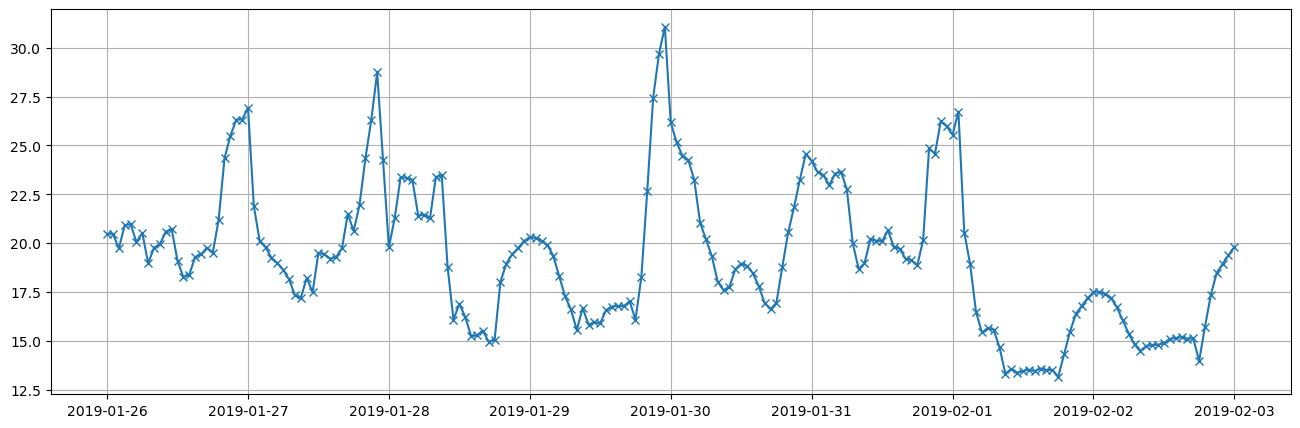

In [12]:
plt.figure(figsize=(16,5))
plt.plot(plt_dates,t2-273.15,"x-")
    
plt.grid()

## start extracting

In [61]:
ts =  "2019-02-02-16"

In [62]:
idx_lat = nearest_latidx
idx_lon = nearest_lonidx
theta_wrf = ds_wrf['T'][:, :, idx_lat, idx_lon] +300
# pressure
geop_wrf = ds_wrf['PH'] + ds_wrf['PHB']
press_wrf = (ds_wrf['P'][:, :, idx_lat, idx_lon] + ds_wrf['PB'][:, :, idx_lat, idx_lon]) *0.01

# temperature
tk_wrf = theta_wrf/((1000/press_wrf)**0.286)
# height
geoh_wrf = geop_wrf[:, :, idx_lat, idx_lon]/9.81

# wind
u_wrf = ds_wrf['U'][:, :, idx_lat, idx_lon]
v_wrf = ds_wrf['V'][:, :, idx_lat, idx_lon]
wspd_wrf = np.sqrt(u_wrf**2+v_wrf**2)

# water vapour mixing ratio
qv_wrf = ds_wrf['QVAPOR'][:, :, idx_lat, idx_lon]

# soil moisture
smois_wrf = ds_wrf['SMOIS'][:, :, idx_lat, idx_lon]

# soil temperature
tslb_wrf = ds_wrf['TSLB'][:, :, idx_lat, idx_lon]


In [63]:
# layers for soil temperature and moisture calculation
# this shall be changed depending on different cases
dz_soil = np.array([0.01, 0.02, 0.04, 0.06, 0.14, 0.26, 0.54, 1.86])

z_soil_palm = np.zeros_like(dz_soil)
z_soil_palm[0] = dz_soil[0]
for i in range(1,len(dz_soil)):
    z_soil_palm[i] = np.sum(dz_soil[:i+1])

# depth of soil layer
zs = ds_wrf['ZS'][0, :].data
# thickness of soil layer
dzs = ds_wrf['DZS'][0, :].data

# # landmask - 1 is land, 0 is water
# landmask = ds_wrf['LANDMASK'][0, idx_lat, idx_lon].data
# TMN - soil temperature at lower boundary
tmn = ds_wrf['TMN'][:, idx_lat, idx_lon]

init_soil_t = np.zeros(dz_soil.shape[0])
init_soil_m = np.zeros(dz_soil.shape[0])

init_soil_t[:] = np.interp(z_soil_palm, zs, tslb_wrf.sel(time=ts).data)
init_soil_m[:] = np.interp(z_soil_palm, zs, smois_wrf.sel(time=ts).data)
deep_soil_t = tmn.sel(time=ts).data

In [64]:
qv_surface = ds_wrf["Q2"].sel(time=ts)[idx_lat, idx_lon]
pt_surface = ds_wrf["T2"].sel(time=ts)[idx_lat, idx_lon]
u_surface = ds_wrf["U10"].sel(time=ts)[idx_lat, idx_lon]
v_surface = ds_wrf["V10"].sel(time=ts)[idx_lat, idx_lon]

In [65]:
z_wrf = ds_wrf["Z"].sel(time=ts)[:,idx_lat, idx_lon]

In [66]:
qv = np.zeros(len(qv_wrf.sel(time=ts).data)+1)
qv[0] = qv_surface.data
qv[1:] = qv_wrf.sel(time=ts).data

pt = np.zeros(len(theta_wrf.sel(time=ts).data)+1)
pt[0] = pt_surface.data
pt[1:] = theta_wrf.sel(time=ts).data

u = np.zeros(len(u_wrf.sel(time=ts).data)+1)
u[0] = u_surface.data
u[1:] = u_wrf.sel(time=ts).data

v = np.zeros(len(v_wrf.sel(time=ts).data)+1)
v[0] = v_surface.data
v[1:] = v_wrf.sel(time=ts).data

zuv_wrf = np.zeros(len(z_wrf.data)+1)
zpq_wrf = np.zeros(len(z_wrf.data)+1)

zuv_wrf[0] = 10
zuv_wrf[1:] = z_wrf.data

zpq_wrf[0] = 2
zpq_wrf[1:] = z_wrf.data

In [67]:
nx                         = 108
ny                         = 108
nz                         = 72
dx                         = 81.0
dy                         = 81.0
dz                         = 18.0
y = np.arange(dy/2,dy*(ny+0.5),dy)
x = np.arange(dx/2,dx*(nx+0.5),dx)
z = np.arange(dz/2, dz*nz, dz)
xu = x + np.gradient(x)/2
xu = xu[:-1]
yv = y + np.gradient(y)/2
yv = yv[:-1]
zw = z + np.gradient(z)/2
zw = zw[:-1]

In [68]:
interp_u = np.interp(z, zuv_wrf, u)
interp_v = np.interp(z, zuv_wrf, v)
interp_pt = np.interp(z, zpq_wrf,pt)
interp_qv = np.interp(z, zpq_wrf,qv)
interp_w = np.zeros_like(zw)

In [69]:
init_msoil_3d = np.tile(init_soil_m[:, np.newaxis, np.newaxis], (1, ny, nx))
init_tsoil_3d = np.tile(init_soil_t[:, np.newaxis, np.newaxis], (1, ny, nx))


In [70]:
outfile_name = "fire_test_dynamic_nighttime_81m"


In [71]:
print(ts)

2019-02-02-16


In [72]:
nc_output = xr.Dataset()
nc_output.attrs['origin_time'] = "2019-02-01 12:00:00 +00" 

nc_output['x'] = xr.DataArray(x, dims=['x'], attrs={'units':'m'})
nc_output['y'] = xr.DataArray(y, dims=['y'], attrs={'units':'m'})
nc_output['z'] = xr.DataArray(z, dims=['z'], attrs={'units':'m'})
nc_output['xu'] = xr.DataArray(xu, dims=['xu'], attrs={'units':'m'})
nc_output['yv'] = xr.DataArray(yv, dims=['yv'], attrs={'units':'m'})
nc_output['zw'] = xr.DataArray(zw, dims=['zw'], attrs={'units':'m'})
nc_output['zsoil'] = xr.DataArray(dz_soil, dims=['zsoil'], attrs={'units':'m'})
nc_output.to_netcdf(outfile_name)

nc_output['init_atmosphere_pt'] = xr.DataArray(interp_pt,dims=['z'],
         attrs={'units':'K', 'lod':np.int32(1)})
nc_output['init_atmosphere_qv'] = xr.DataArray(interp_qv,dims=['z'],
         attrs={'units':'kg/kg', 'lod':np.int32(1)})
nc_output['init_atmosphere_u'] = xr.DataArray(interp_u,dims=['z'],
         attrs={'units':'m/s', 'lod':np.int32(1)})
nc_output['init_atmosphere_v'] = xr.DataArray(interp_v,dims=['z'],
         attrs={'units':'m/s', 'lod':np.int32(1)})
nc_output['init_atmosphere_w'] = xr.DataArray(interp_w,dims=['zw'],
         attrs={'units':'m/s', 'lod':np.int32(1)})

nc_output['init_soil_m'] = xr.DataArray(init_msoil_3d, dims=['zsoil','y','x'], 
         attrs={'units':'m^3/m^3','lod':np.int32(2)}) 
nc_output['init_soil_t'] = xr.DataArray(init_tsoil_3d, dims=['zsoil','y','x'], 
         attrs={'units':'K', 'lod':np.int32(1)}) 


for var in nc_output.data_vars:
    encoding = {var: {'dtype': 'float32', '_FillValue': -9999, 'zlib':True}}
    nc_output[var].to_netcdf(outfile_name, mode ='a', encoding=encoding)
    
nc_output.close()

In [24]:
def calc_gradient(z, vert, step):
        '''
        z : vertical heights
        vert : vertical profiles
        '''
        lvl = [z[0]]
        pr = [vert[0]]
        mask_lower = z<=100
        mask_upper = z>100
        for j in range(0,len(z[mask_lower])):
            if j==0:
                continue
            else:
                lvl.append(z[mask_lower][j])
                pr.append(vert[mask_lower][j])
        for i in range(0, len(z[mask_upper]), step):
#                 if i==0:
#                     continue
#                 else:
                    lvl.append(z[mask_upper][i])
                    pr.append(vert[mask_upper][i])
            
        # pr.append(vert[-1])
        gradient = []
        
        for j in range(1,len(pr)):
            # if j
            gradient.append( (pr[j]-pr[j-1])*100 / (lvl[j]-lvl[j-1]) )
            # else:
            #     gradient.append( (pr[j]-pr[j-1]) / (z[-1]-lvl[j]) )
        lvl.remove(lvl[-1])
        return(gradient, lvl)

In [25]:
pt_vertical_gradient, pt_gradient_level = calc_gradient(zpq_wrf, pt, 4)
qv_vertical_gradient, qv_gradient_level = calc_gradient(zpq_wrf, qv, 4)

In [26]:
def write_line(var_name, var_data):
    var_data = np.around(var_data, 8)
    if type(var_data) == np.float32 or type(var_data) == np.float64:
        line = var_name + ' = ' + '{:.6f}'.format(var_data) + ', '  +'\n' +'\n'
    else:
        line = var_name + ' = ' + ', '.join(map(str, var_data)) +'\n' +'\n'

    return line

In [28]:
with open('bottle_lake_night_wrf_namelist_test', 'w') as namelist:
        namelist.write( write_line('uv_heights', zuv_wrf) )
        namelist.write( write_line('u_profile', u) )
        namelist.write( write_line('v_profile', v) )
        namelist.write( write_line('pt_surface', pt_surface.data) )
        namelist.write( write_line('pt_vertical_gradient', pt_vertical_gradient) )
        namelist.write( write_line('pt_vertical_gradient_level', pt_gradient_level) )
        namelist.write( write_line('q_surface', qv_surface.data) )
        namelist.write( write_line('q_vertical_gradient', qv_vertical_gradient) )
        namelist.write( write_line('q_vertical_gradient_level', qv_gradient_level) )
        namelist.write('& land_surface_model \n' )
        namelist.write( write_line('dz_soil', dz_soil) )
        namelist.write( write_line('soil_moisture', init_soil_m) )
        namelist.write( write_line('soil_temperature', init_soil_t) )
        namelist.write( write_line('deep_soil_temperature', deep_soil_t) )

In [32]:
len([-0.56380057, -0.80171591, -0.82185549, -0.79710972, -0.79621291, -0.93017983, 0.53569478, 1.33466887, 0.58303714, 2.40685105, 0.02670245, -1.85982168, -0.8354727, 1.3920927, 2.23414993, 2.17428112, 0.55182743, -1.90035725, -4.27015305, -6.1294384])

20